In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings('ignore')

#### 1- Load the data

In [3]:
# Load dataset
df = pd.read_csv('/Users/mustafaaldabbas/Documents/GitHub/Machine_learning_superstore/df_cleaned.csv')

# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Display basic info and summary statistics
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   invoice_id               1000 non-null   object        
 1   branch                   1000 non-null   object        
 2   city                     1000 non-null   object        
 3   customer_type            1000 non-null   object        
 4   gender                   1000 non-null   object        
 5   product_line             1000 non-null   object        
 6   unit_price               1000 non-null   float64       
 7   quantity                 1000 non-null   int64         
 8   tax_5                    1000 non-null   float64       
 9   total                    1000 non-null   float64       
 10  date                     1000 non-null   datetime64[ns]
 11  time                     1000 non-null   object        
 12  payment                  1000 non-n

### Sales over time 

In [4]:
# Convert the date column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Extract year, month, and day from the date column
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Aggregate sales data by date
sales_by_date = df.groupby('date')['total'].sum().reset_index()

# Extract year, month, and day from the date column
sales_by_date['year'] = sales_by_date['date'].dt.year
sales_by_date['month'] = sales_by_date['date'].dt.month
sales_by_date['day'] = sales_by_date['date'].dt.day

# Display the first few rows of the aggregated sales data
sales_by_date.head()

,date,total,year,month,day
0,2019-01-01,4745.1810,2019,1,1
1,2019-01-02,1945.5030,2019,1,2
2,2019-01-03,2078.1285,2019,1,3
3,2019-01-04,1623.6885,2019,1,4
4,2019-01-05,3536.6835,2019,1,5


### EDA Performing 

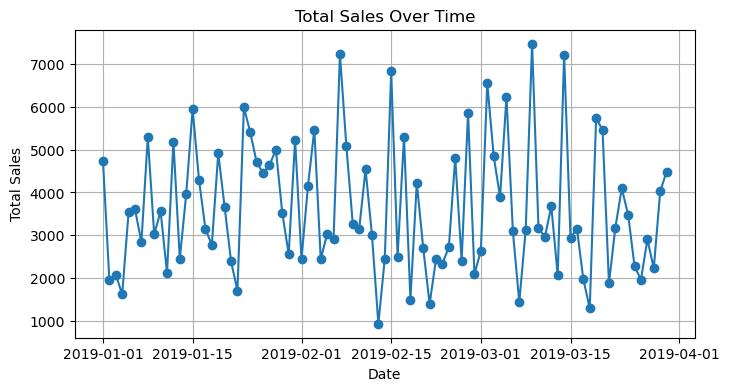

In [5]:
# Plot the total sales over time
plt.figure(figsize=(8, 4))
plt.plot(sales_by_date['date'], sales_by_date['total'], marker='o')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

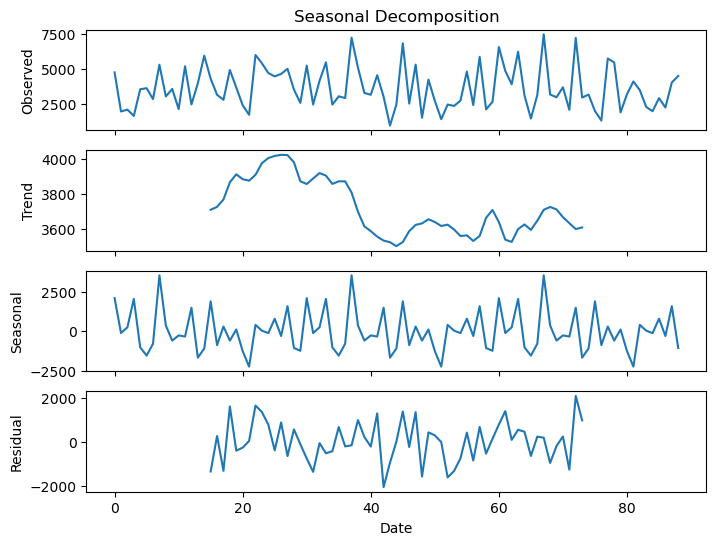

In [6]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_by_date['total'], model='additive', period=30)

# Plot the decomposition results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residual')
ax4.set_xlabel('Date')

plt.show()

### corrleation heatmap

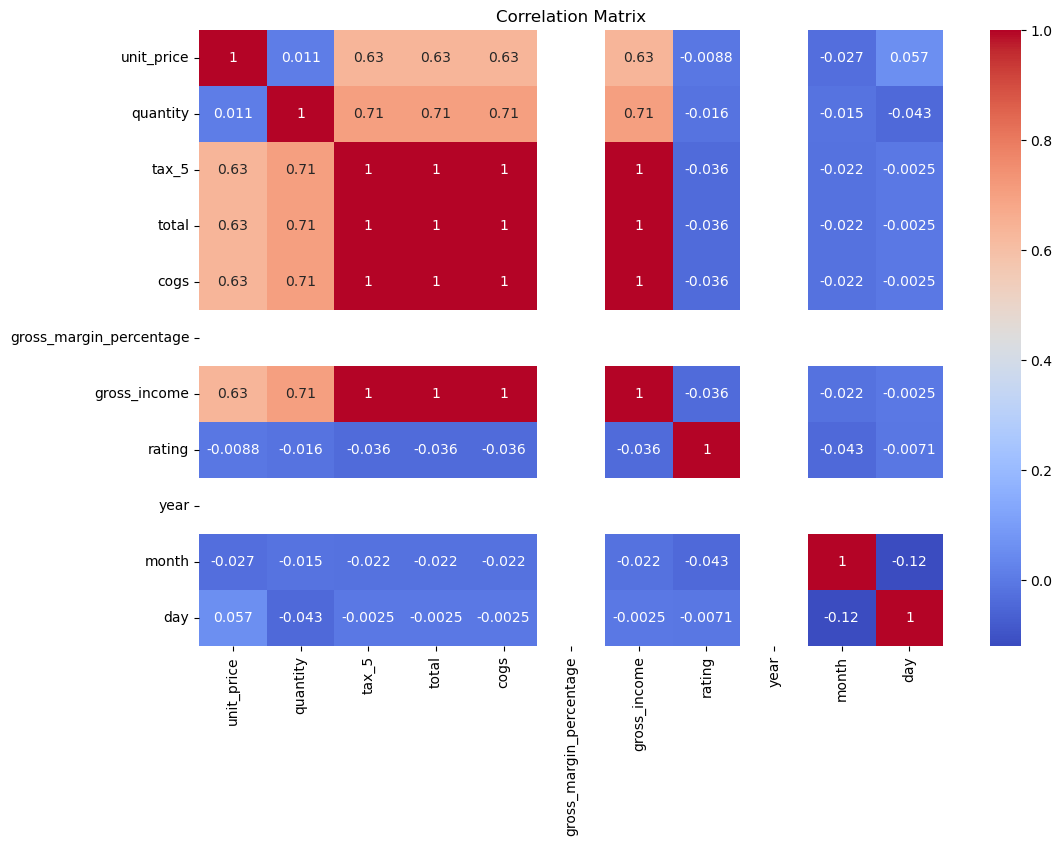

In [7]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### 4 Data Preprocessing and Feature Engineering


In [8]:
# Extract additional date features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek

# Feature Engineering: Combine categorical variables
df['gender_city'] = df['gender'] + '_' + df['city']
df['productline_gender'] = df['product_line'] + '_' + df['gender']
df['customertype_gender'] = df['customer_type'] + '_' + df['gender']



In [9]:

# Encode categorical variables using OneHotEncoder
categorical_columns = ['gender_city', 'productline_gender', 'customertype_gender']
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_columns = onehot_encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_columns, columns=onehot_encoder.get_feature_names_out(categorical_columns))



In [10]:
encoded_df

,gender_city_Female_Mandalay,gender_city_Female_Naypyitaw,gender_city_Female_Yangon,gender_city_Male_Mandalay,gender_city_Male_Naypyitaw,gender_city_Male_Yangon,productline_gender_Electronic accessories_Female,productline_gender_Electronic accessories_Male,productline_gender_Fashion accessories_Female,productline_gender_Fashion accessories_Male,...,productline_gender_Health and beauty_Female,productline_gender_Health and beauty_Male,productline_gender_Home and lifestyle_Female,productline_gender_Home and lifestyle_Male,productline_gender_Sports and travel_Female,productline_gender_Sports and travel_Male,customertype_gender_Member_Female,customertype_gender_Member_Male,customertype_gender_Normal_Female,customertype_gender_Normal_Male
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:

# Encode categorical variables using OneHotEncoder
categorical_columns = ['gender_city', 'productline_gender', 'customertype_gender']
onehot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoded_columns = onehot_encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_columns, columns=onehot_encoder.get_feature_names_out(categorical_columns))

# Extract relevant columns
relevant_columns = encoded_df.columns[encoded_df.columns.str.contains('gender_city') |
                                      encoded_df.columns.str.contains('productline_gender') |
                                      encoded_df.columns.str.contains('customertype_gender')]

# Merge encoded columns back to the dataframe
df = pd.concat([df, encoded_df[relevant_columns]], axis=1)

# Drop original combined categorical columns
df.drop(columns=categorical_columns, inplace=True)

# Display the dataframe to confirm changes
print("DataFrame after encoding and selecting relevant columns:", df.head())

# Display the names of the relevant columns
relevant_columns


DataFrame after encoding and selecting relevant columns:     invoice_id branch       city customer_type  gender  \
0  750-67-8428      A     Yangon        Member  Female   
1  226-31-3081      C  Naypyitaw        Normal  Female   
2  631-41-3108      A     Yangon        Normal    Male   
3  123-19-1176      A     Yangon        Member    Male   
4  373-73-7910      A     Yangon        Normal    Male   

             product_line  unit_price  quantity    tax_5     total  ...  \
0       Health and beauty       74.69         7  26.1415  548.9715  ...   
1  Electronic accessories       15.28         5   3.8200   80.2200  ...   
2      Home and lifestyle       46.33         7  16.2155  340.5255  ...   
3       Health and beauty       58.22         8  23.2880  489.0480  ...   
4       Sports and travel       86.31         7  30.2085  634.3785  ...   

  productline_gender_Health and beauty_Female  \
0                                         1.0   
1                                         0.0

Index(['gender_city_Female_Mandalay', 'gender_city_Female_Naypyitaw',
       'gender_city_Female_Yangon', 'gender_city_Male_Mandalay',
       'gender_city_Male_Naypyitaw', 'gender_city_Male_Yangon',
       'productline_gender_Electronic accessories_Female',
       'productline_gender_Electronic accessories_Male',
       'productline_gender_Fashion accessories_Female',
       'productline_gender_Fashion accessories_Male',
       'productline_gender_Food and beverages_Female',
       'productline_gender_Food and beverages_Male',
       'productline_gender_Health and beauty_Female',
       'productline_gender_Health and beauty_Male',
       'productline_gender_Home and lifestyle_Female',
       'productline_gender_Home and lifestyle_Male',
       'productline_gender_Sports and travel_Female',
       'productline_gender_Sports and travel_Male',
       'customertype_gender_Member_Female', 'customertype_gender_Member_Male',
       'customertype_gender_Normal_Female', 'customertype_gender_Nor

In [12]:
# Aggregate sales data by date
sales_by_date = df.groupby('date')['total'].sum().reset_index()

# Extract year, month, day, and dayofweek from the date column
sales_by_date['year'] = sales_by_date['date'].dt.year
sales_by_date['month'] = sales_by_date['date'].dt.month
sales_by_date['day'] = sales_by_date['date'].dt.day
sales_by_date['dayofweek'] = sales_by_date['date'].dt.dayofweek

sales_by_date 

,date,total,year,month,day,dayofweek
0,2019-01-01,4745.1810,2019,1,1,1
1,2019-01-02,1945.5030,2019,1,2,2
2,2019-01-03,2078.1285,2019,1,3,3
3,2019-01-04,1623.6885,2019,1,4,4
4,2019-01-05,3536.6835,2019,1,5,5
...,...,...,...,...,...,...
84,2019-03-26,1962.5130,2019,3,26,1
85,2019-03-27,2902.8195,2019,3,27,2
86,2019-03-28,2229.4020,2019,3,28,3
87,2019-03-29,4023.2430,2019,3,29,4


#### 5.  Time Series Slicing and Model Training


In [29]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Aggregate sales data by date and include the encoded features
sales_by_date = df.groupby('date').sum().reset_index()

# Extract year, month, day, and dayofweek from the date column
sales_by_date['year'] = sales_by_date['date'].dt.year
sales_by_date['month'] = sales_by_date['date'].dt.month
sales_by_date['day'] = sales_by_date['date'].dt.day
sales_by_date['dayofweek'] = sales_by_date['date'].dt.dayofweek

# Define feature engineering combinations
feature_combinations = [
    ['year', 'month', 'day', 'dayofweek'],
    ['year', 'month', 'day', 'dayofweek'] + list(relevant_columns[relevant_columns.str.contains('gender_city')]),
    ['year', 'month', 'day', 'dayofweek'] + list(relevant_columns[relevant_columns.str.contains('productline_gender')]),
    ['year', 'month', 'day', 'dayofweek'] + list(relevant_columns[relevant_columns.str.contains('customertype_gender')]),
    ['year', 'month', 'day', 'dayofweek'] + list(relevant_columns)
]

# Define models
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'RandomForest': RandomForestRegressor(),
    'GradientBoosting': GradientBoostingRegressor(),
    'KNN': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(),
    'LightGBM': LGBMRegressor(),
    'CatBoost': CatBoostRegressor(),
}

# Initialize results dictionary
results = {}

# Loop through feature combinations and models
for features in feature_combinations:
    feature_name = '_'.join(features)
    
    # Prepare data with selected features
    sales_features = sales_by_date[['date'] + features + ['total']].copy()
    
    # Prepare training and testing data
    X = sales_features[features]
    y = sales_features['total']
    
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    for model_name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Predict and evaluate
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Store results
        results[f'{model_name}_{feature_name}'] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Display results
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model_Features'}, inplace=True)
results_df.sort_values(by='MSE', inplace=True)

results_df  # Display the top 10 results


Learning rate set to 0.026957
0:	learn: 1503.7844028	total: 203us	remaining: 203ms
1:	learn: 1499.0817528	total: 345us	remaining: 173ms
2:	learn: 1494.9995683	total: 473us	remaining: 157ms
3:	learn: 1492.0911012	total: 634us	remaining: 158ms
4:	learn: 1486.0807776	total: 788us	remaining: 157ms
5:	learn: 1484.8233213	total: 837us	remaining: 139ms
6:	learn: 1478.9728807	total: 964us	remaining: 137ms
7:	learn: 1473.2576574	total: 1.1ms	remaining: 136ms
8:	learn: 1468.3037207	total: 1.24ms	remaining: 136ms
9:	learn: 1462.3248374	total: 1.36ms	remaining: 135ms
10:	learn: 1456.3841916	total: 1.49ms	remaining: 134ms
11:	learn: 1454.1820524	total: 1.62ms	remaining: 134ms
12:	learn: 1453.8241526	total: 1.67ms	remaining: 127ms
13:	learn: 1449.6128648	total: 1.81ms	remaining: 128ms
14:	learn: 1443.1362222	total: 1.94ms	remaining: 128ms
15:	learn: 1437.5486494	total: 2.07ms	remaining: 127ms
16:	learn: 1431.8495793	total: 2.2ms	remaining: 127ms
17:	learn: 1426.8886277	total: 2.33ms	remaining: 127ms

,Model_Features,MSE,MAE,R2
12,LightGBM_year_month_day_dayofweek_gender_city_...,9.399457e+05,804.606115,0.598387
33,LightGBM_year_month_day_dayofweek_gender_city_...,9.807308e+05,810.052307,0.580961
30,GradientBoosting_year_month_day_dayofweek_gend...,1.003726e+06,791.425764,0.571135
32,XGBoost_year_month_day_dayofweek_gender_city_F...,1.067542e+06,898.408303,0.543868
11,XGBoost_year_month_day_dayofweek_gender_city_F...,1.068033e+06,912.654165,0.543659
34,CatBoost_year_month_day_dayofweek_gender_city_...,1.148895e+06,858.048838,0.509109
13,CatBoost_year_month_day_dayofweek_gender_city_...,1.156753e+06,860.186072,0.505751
15,RandomForest_year_month_day_dayofweek_productl...,1.180440e+06,862.820904,0.495630
29,RandomForest_year_month_day_dayofweek_gender_c...,1.206103e+06,906.804523,0.484665
27,CatBoost_year_month_day_dayofweek_customertype...,1.282099e+06,908.366884,0.452194


### 6 Hyperparameter Tuning for the Best Model


### Hypertunning the best model 

In [30]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Define the best features based on the best-performing model
best_features = ['year', 'month', 'day', 'dayofweek'] + list(relevant_columns[relevant_columns.str.contains('gender_city')])
X = sales_by_date[best_features]
y = sales_by_date['total']

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100]
}

lgb = LGBMRegressor()
grid_search = GridSearchCV(estimator=lgb, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=5), n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Final evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Final MSE: {mse}')
print(f'Final MAE: {mae}')
print(f'Final R2: {r2}')


Best parameters found:  {'learning_rate': 0.1, 'max_depth': None, 'n_estimators': 100, 'num_leaves': 31}
Best score:  2308139.120328372
Final MSE: 939945.6867988987
Final MAE: 804.6061154729301
Final R2: 0.5983868839549669


### 7 Predict Future Sales


#### Predictions based only on time series 

In [23]:
# Define the best features including the encoded categorical values
best_features = ['year', 'month', 'day', 'dayofweek'] + list(relevant_columns)

# Ensure the columns in sales_by_date match the columns used in best_features
missing_cols = set(best_features) - set(sales_by_date.columns)
for col in missing_cols:
    sales_by_date[col] = 0

# Reorder sales_by_date to match the order of best_features
sales_by_date = sales_by_date[['date'] + best_features + ['total']]

# Prepare training data
X = sales_by_date[best_features]
y = sales_by_date['total']

# Create the best model using the best parameters found
best_model = LGBMRegressor(
    learning_rate=0.1,
    max_depth=None,
    n_estimators=100,
    num_leaves=31
)

# Train the model on the entire dataset
best_model.fit(X, y)




LGBMRegressor(max_depth=None)

In [24]:
# Generate the next 7 days of dates
last_date = sales_by_date['date'].max()
future_dates = pd.date_range(start=last_date, periods=8, closed='right')

# Prepare the feature set for future dates based only on time-related features
future_data_time_only = pd.DataFrame({
    'date': future_dates,
    'year': future_dates.year,
    'month': future_dates.month,
    'day': future_dates.day,
    'dayofweek': future_dates.dayofweek
})

# Add placeholder columns for the encoded categorical features
for col in relevant_columns:
    future_data_time_only[col] = 0

# Ensure the columns in future_data_time_only match the columns used in best_features
future_data_time_only = future_data_time_only[best_features]

# Predict future sales using time-related features
X_future_time_only = future_data_time_only[best_features]
future_sales_predictions_time_only = best_model.predict(X_future_time_only)

# Display the future sales predictions based only on time-related features
future_sales_time_only_df = pd.DataFrame({'date': future_dates, 'predicted_sales': future_sales_predictions_time_only})
print("Future sales predictions based only on time-related features:")
print(future_sales_time_only_df)


Future sales predictions based only on time-related features:
        date  predicted_sales
0 2019-03-31       981.244838
1 2019-04-01       651.768896
2 2019-04-02       651.768896
3 2019-04-03       651.768896
4 2019-04-04       717.931386
5 2019-04-05       753.052760
6 2019-04-06       753.052760
